### Script per la creazione del dataset di spettrogrammi MEL su segmenti da 6 secondi

In [1]:
import os, sys
import numpy as np
import torch
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
torch.manual_seed(184)
torch.cuda.manual_seed(184)

In [2]:
patiens = [ 1006,1000,1026,1088,1057, 1020, 1014, 1106, 1037,1008,1120, 1045, 1016, 1059, 1041, 
       1028, 1095, 1084, 1093, 1112, 1073, 1104, 1043, 1018,
        1082, 1022, 1110, 1039, 1089,  1116, 1010, 1097, 
       1108, 1069, 1118, 1086, 1024, 1071]
print(len(patiens))

38


set some parameters

In [3]:
wav_path = "/disks/disk1/adanna/PSG_Audio/EDF/"
dest_path = "/disks/disk1/adanna/MELSP_6S/"
meta_file = "/home/adanna/Codice/apnea_detection_v3/meta.csv"
SR = 16000 # working sample rate
P_n = 1097 # Patient number without leading zeros
E_type = ['ObstructiveApnea', 'CentralApnea', 'MixedApnea', 'Hypopnea'] # desired apnea type(s)
context_s = 6 # secondi di contesto

In [6]:
# create destination folders or rise error if already exist
# crea la cartella di destinazione per ogni paziente all'interno della quale inserisce altre due cartelle "apnea" "non apnea"
patient_dest_path = os.path.join(dest_path, 'Pprova'+str(P_n))
apnea_dest_path = os.path.join(dest_path, 'Pprova'+str(P_n), 'prova_apnea')
nonapnea_dest_path = os.path.join(dest_path, 'Pprova'+str(P_n), 'prova_nonapnea')
if not os.path.exists(patient_dest_path):
    os.makedirs(patient_dest_path)
    os.makedirs(apnea_dest_path)
    os.makedirs(nonapnea_dest_path)
else:
    raise Exception(f'Destination folder for patient {str(P_n)} already exists!')

read meta file

In [7]:
#E_type sono i 4 tipi di apnea
#crea un dataframe di pandas accedendo al file meta.csv
meta_df = pd.read_csv(meta_file, low_memory=False)
#estrae tutte le righe corrispondenti ai tipi di apnea definiti in E_type
apnea_df = meta_df.loc[(meta_df['Type'] == E_type[0])|(meta_df['Type'] == E_type[1])|(meta_df['Type'] == E_type[2])|(meta_df['Type'] == E_type[3])]
#estrae tutte le righe relative ad uno specifico paziente P_n e le conta per sapere il numero di eventi di apnea 
apnea_df = apnea_df.loc[apnea_df["Patient_ID"] == P_n]
print(f'Found {len(apnea_df)} apnea events from patient #{P_n}')

Found 197 apnea events from patient #1097


In [8]:
# in wav_files ci sarà una lista di stringhe corrispondenti ai file audio
wav_files = os.listdir(os.path.join(wav_path, ("0000" + str(P_n))))
s_len = 0.0
for wf in wav_files:
    # get wav file duration without opening
    d = librosa.get_duration(path = os.path.join(wav_path, ("0000" + str(P_n)), wf))
    s_len += d #somma le durate in ogni file per avere la durata complessiva dei file audio per un singolo paziente
print(f'Found {s_len} seconds of audio for patient {P_n}')

#accedendo al dataframe definito prima somma del campo durata di ogni singolo evento di apnea per un paziente 
print(f'Found {apnea_df["Duration"].sum()} seconds of apnea events for patient {P_n}')

Found 19239.0 seconds of audio for patient 1097
Found 2232.5 seconds of apnea events for patient 1097


build label mask

In [9]:
#SR è il sample rate, descrive in hertz il numero dei campioni presenti in un secondo di segnale digitale.
# torch.zeros ritorna un tensore riempito con il valore 0, la lunghezza del tensore è data dal valore in input, in questo caso pari alla durata in secondi per il sample rate
apneas_mask = torch.zeros(int(s_len*SR))
#itera su tutte le righe del df
for idx, row in apnea_df.iterrows():
    # moltiplica per il SR il valore di Start e di Duration
    start = int(row['Start']*SR) 
    dur = int(row['Duration']*SR)
    # modifica la maschera impostando a 1.0 i valori corrispondenti all'intervallo di campioni che rappresentano l'episodio di apnea.
    apneas_mask[start:start + dur] = 1.0


# gli eventi di apnea vengono rappresentati in una maschera binaria con gli 1

concatenate 1-hour audio files into a single array

In [10]:
# crea un array numpy di zeri con due dimensioni date dagli argomenti, quindi dalla lunghezza del file audio e da 3600*SR (numero di campioni in un'ora)
y_block = np.zeros((len(wav_files), 3600*SR))
for w in range(len(wav_files)):
    # nome del file audio
    fname = "0000" + str(P_n) + "-100507[00" + str(w+1) + "].wav"
    # il file audio viene caricato dal percorso specificato. Il segnale audio y è campionato al sample rate SR.
    y, _ = librosa.load(os.path.join(wav_path, ("0000" + str(P_n)), fname), sr=SR)
    # Il segnale audio y viene inserito nella riga corrispondente di y_block
    y_block[w,0:y.shape[0]] += y
#appiattisce l'array ad 1 dimensione
y_all = y_block.reshape(-1)

#in questo blocco vengono concatenati tutti i pezzi di file audio per andare a costituire un'ora di audio

save MEL spectrograms into two separate folders: apnea and nonapnea

In [23]:
# range inizia da 0 e va fino a apneas_mask.shape[0] (lunghezza della maschera di apnee), con passi di (context_s*SR)
#context_s sono i secondi di contesto, pari a 6 in questo caso
spectrograms=[]
spectrograms_nonapnea=[]
for n, c in enumerate(tqdm(range(0,apneas_mask.shape[0],(context_s*SR)))):
    #se la somma degli elementi nella maschera nell'intervallo specificato di 6 secondi è uguale a zero, vuol dire che non c'è un episodio di apnea che invece è identificato da 1
    if sum(apneas_mask[c:c+(context_s*SR)]) == 0: # IF NON APNEA
        try:
            y_chunk = y_all[c:c+(context_s*SR)]
            #crea lo spettrogramma di quella specifica parte identificata come non apnea 
            S2 = librosa.feature.melspectrogram(y=y_chunk, sr=SR, hop_length=185, n_mels=64)
            #Convert a power spectrogram (amplitude squared) to decibel (dB) units
            S2_dB = librosa.power_to_db(S2, ref=np.max) # shape [64,519]
            #crea un tensore di elementi float a partire dall'array numpy
            S2_dB = torch.from_numpy(S2_dB).float()
            #salva il tensore a destinazione
            if len(spectrograms_nonapnea) < 4:
                spectrograms_nonapnea.append(S2_dB)
            #torch.save(S2_dB, os.path.join(nonapnea_dest_path, str(n) + '.pth'))
        except:
            print(f'error')
    elif sum(apneas_mask[c:c+(context_s*SR)]) == (context_s*SR): # IF FULL 6s APNEA
        try:
            #stesso procedimento precedente ma cambiando il path di destinazione
            y_chunk = y_all[c:c+(context_s*SR)]
            S2 = librosa.feature.melspectrogram(y=y_chunk, sr=SR, hop_length=185, n_mels=64)
            S2_dB = librosa.power_to_db(S2, ref=np.max) # shape [64,519]
            S2_dB = torch.from_numpy(S2_dB).float()
            #torch.save(S2_dB, os.path.join(apnea_dest_path, str(n) + '.pth'))
            if len(spectrograms) < 4:
                spectrograms.append(S2_dB)
            else:
                break
        except:
            print(f'error')


  0%|          | 0/3207 [00:00<?, ?it/s]

  3%|▎         | 85/3207 [00:34<21:15,  2.45it/s]


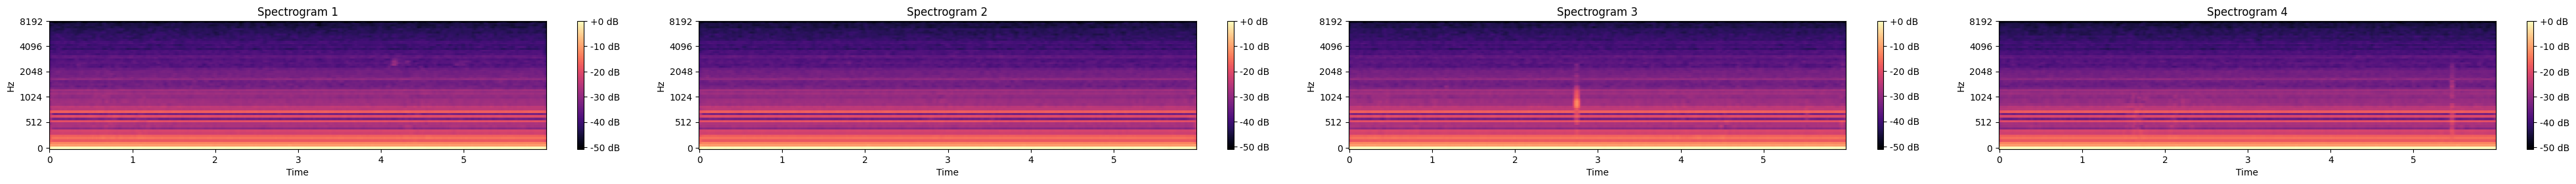

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 5))
for i, S2_dB in enumerate(spectrograms):
    plt.subplot(2, 5, i+1)
    librosa.display.specshow(S2_dB.numpy(), sr=SR, hop_length=185, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram {i+1}')
plt.tight_layout()
plt.show()

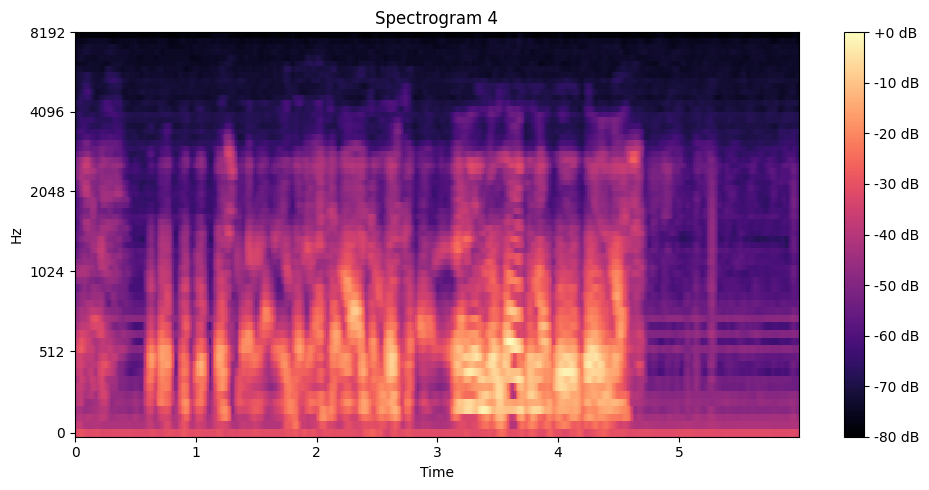

In [38]:
S2_dB = spectrograms_nonapnea[0]  # Il quarto elemento (indice 3)

plt.figure(figsize=(10, 5))  # Dimensione della figura per visualizzare un singolo spettrogramma
librosa.display.specshow(S2_dB.numpy(), sr=SR, hop_length=185, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram 4')
plt.tight_layout()
plt.show()

In [59]:
apnea_melsp = os.listdir(apnea_dest_path)
nonapnea_melsp = os.listdir(nonapnea_dest_path)
print(f'Saved {len(apnea_melsp)} MELSP chunks of apnea, and {len(nonapnea_melsp)} MELSP chunks of nonapnea')

Saved 15 MELSP chunks of apnea, and 102 MELSP chunks of nonapnea
